Extracting EDF parameters from /content/P6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 531499  =      0.000 ...  1062.998 secs...


/tmp/ipython-input-11-2726483139.py:49: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf('/content/P6.edf', preload=True, infer_types=True)


Used Annotations descriptions: [np.str_('Trigger#100'), np.str_('Trigger#110'), np.str_('Trigger#200'), np.str_('Trigger#220'), np.str_('Trigger#301'), np.str_('Trigger#302'), np.str_('Trigger#303')]
Triggers (With time stamps)
      Time Stamp Trigger
0          3788     301
1          3819     220
2          4797     220
3          5795     220
4          6793     220
..          ...     ...
346      523657     200
347      524652     220
348      525652     220
349      526652     200
350      527131     100

[351 rows x 2 columns]
Trigger Received: 301 at time stamp 3788
Trigger Received: 302 at time stamp 52349
Trigger Received: 303 at time stamp 108434
Trigger Received: 302 at time stamp 199970
Trigger Received: 303 at time stamp 257637
Trigger Received: 301 at time stamp 305408
Trigger Received: 303 at time stamp 396827
Trigger Received: 301 at time stamp 443365
Trigger Received: 302 at time stamp 488649
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.6s finished


Plotting power spectral density (dB=True).
Figure(1000x350)
<ICA | no decomposition, method: infomax>
Fitting ICA to data using 32 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['Fp1']
Artifact detected in [15100, 15200]
Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 23.3s.
<ICA | raw data decomposition, method: infomax (fit in 500 iterations on 53000 samples), 18 ICA components (32 PCA components available), channel types: eeg, no sources marked for exclusion>


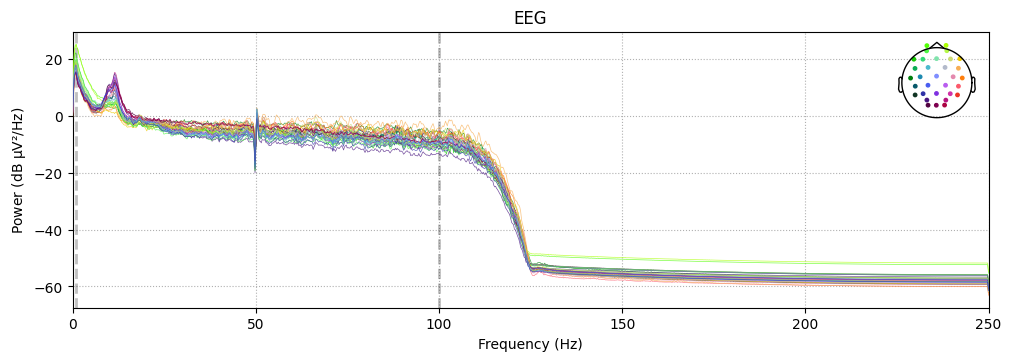

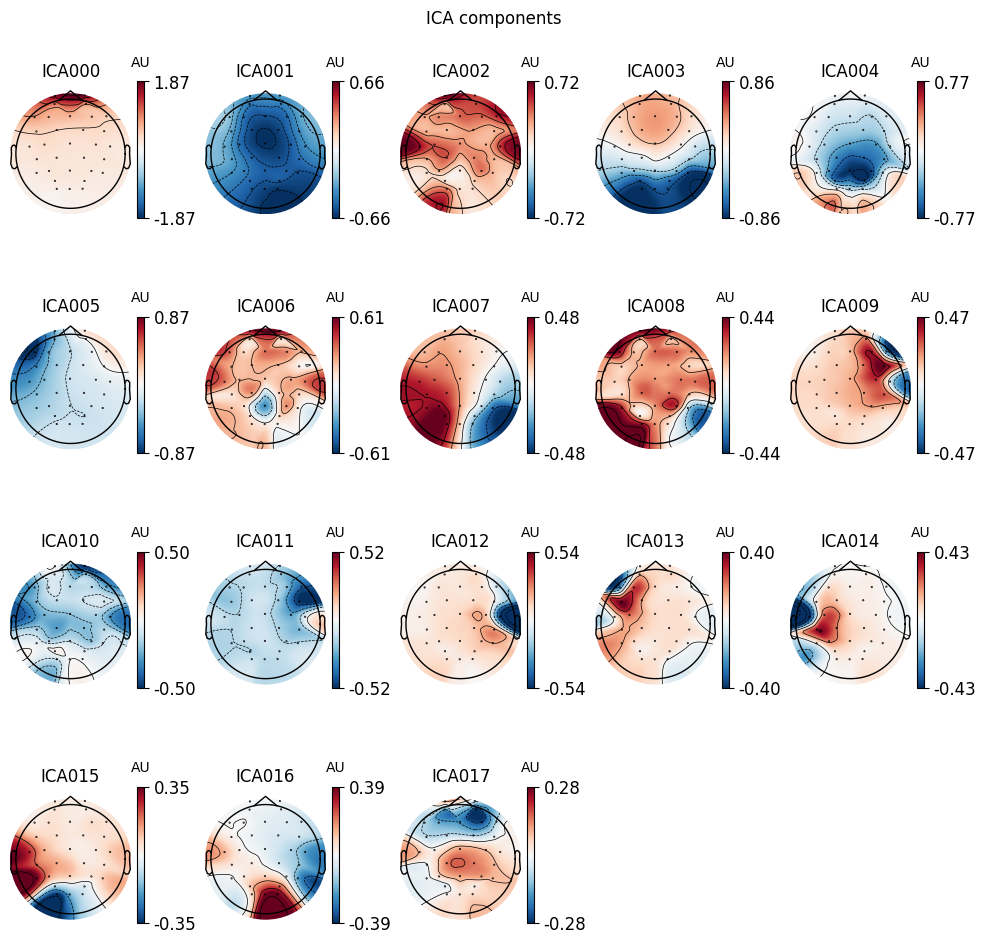

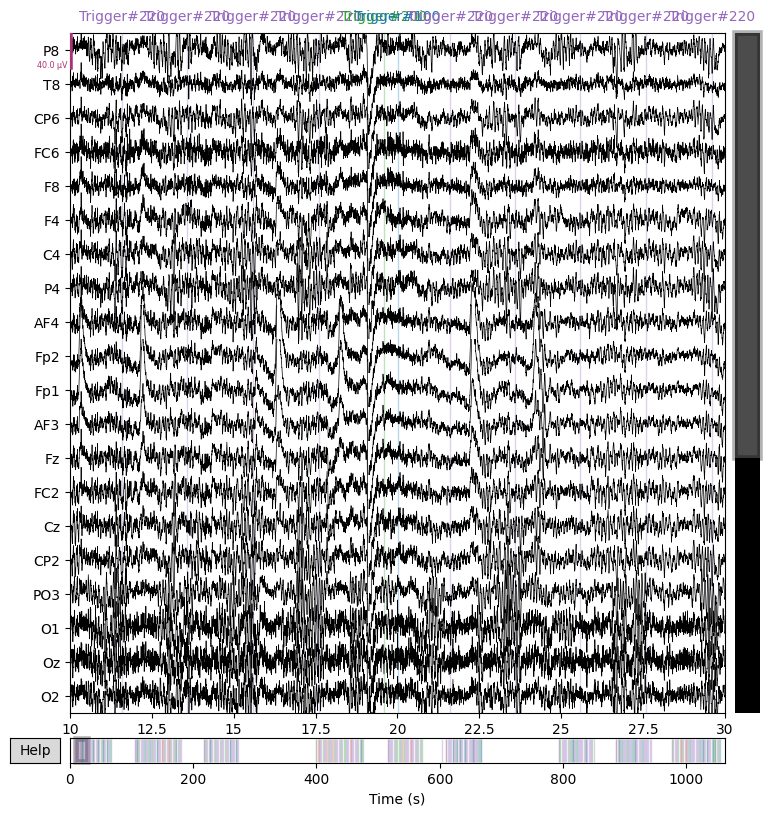

Creating RawArray with float64 data, n_channels=18, n_times=531500
    Range : 0 ... 531499 =      0.000 ...  1062.998 secs
Ready.


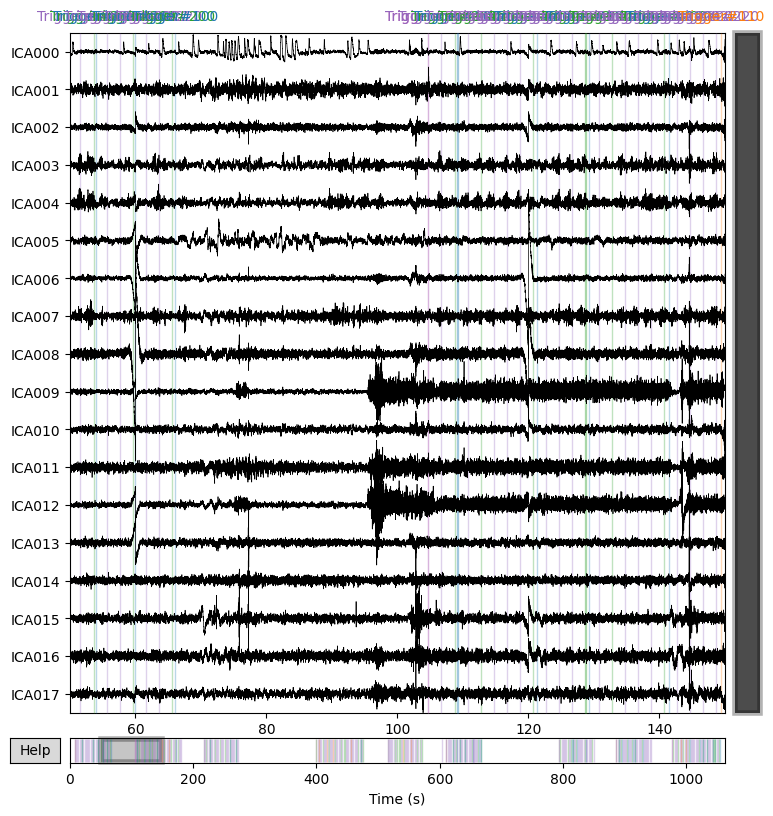

Figure(800x800)
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=18, n_times=531500
    Range : 0 ... 531499 =      0.000 ...  1062.998 secs
Ready.


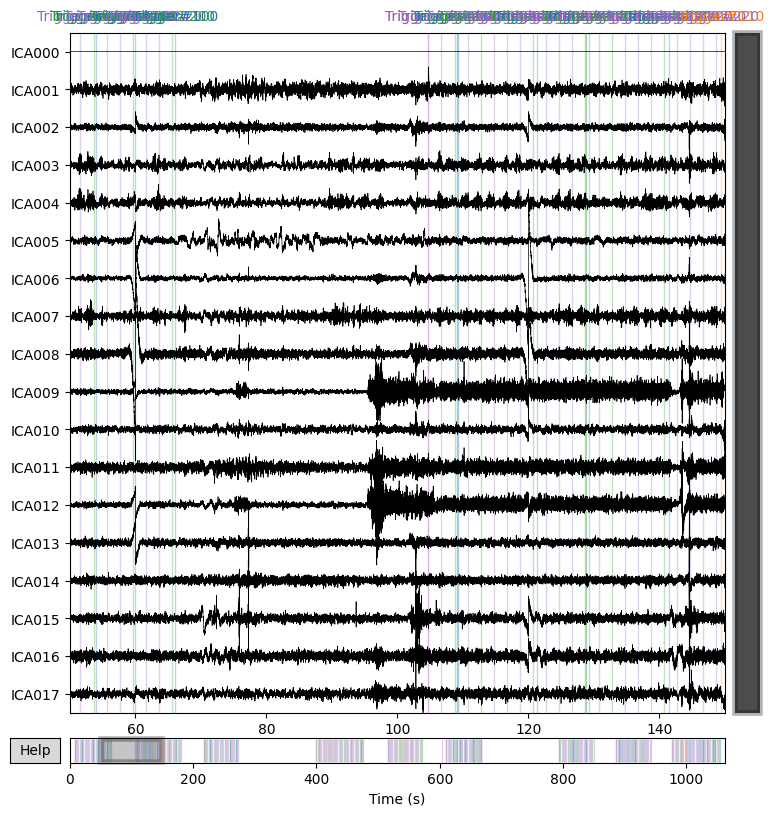

Figure(800x800)


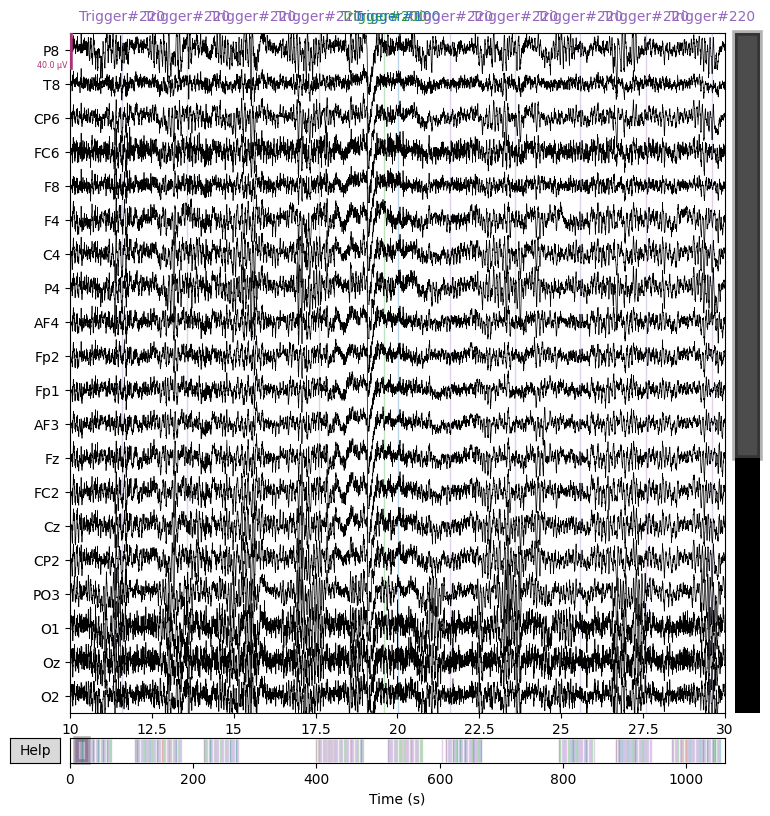

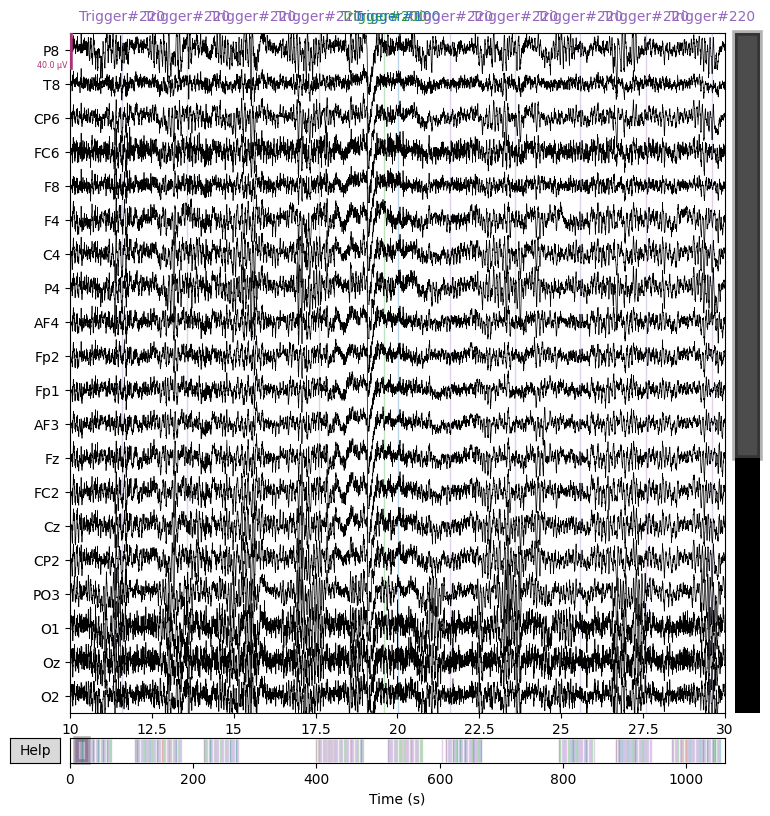

In [ ]:
!pip install mne
!pip install mne-icalabel

import matplotlib.pyplot as plt
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
from mne_icalabel import label_components
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import pywt

eeg_channels =['P8',
 'T8',
 'CP6',
 'FC6',
 'F8',
 'F4',
 'C4',
 'P4',
 'AF4',
 'Fp2',
 'Fp1',
 'AF3',
 'Fz',
 'FC2',
 'Cz',
 'CP2',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'Pz',
 'CP1',
 'FC1',
 'P3',
 'C3',
 'F3',
 'F7',
 'FC5',
 'CP5',
 'T7',
 'P7']

raw = mne.io.read_raw_edf('/content/P6.edf', preload=True, infer_types=True)
eeg_raw=raw.pick(mne.pick_channels(raw.info['ch_names'], include=eeg_channels))

#Set Montage
montage = mne.channels.make_standard_montage('standard_1020')
eeg_raw.set_montage(montage)

events = mne.events_from_annotations(raw)
triggerTimeStamps = pd.DataFrame(events[0], columns=['Time Stamp', "", "Trigger"]).drop([""], axis = 1)
replaceDict = dict()
for i,j in events[1].items():
  replaceDict[j] = i.replace("Trigger#", "")
triggerTimeStamps.replace(replaceDict, inplace=True)
print("Triggers (With time stamps)\n", triggerTimeStamps)

triggerTimeStamps[(triggerTimeStamps['Trigger']=='220') & (triggerTimeStamps['Time Stamp'] < 199970)]

bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-13 Hz)': (8, 13), 'Beta (13-32 Hz)': (13, 32),
         'Gamma (32-100 Hz)': (32, 100)}
i = 0
triggerTime = []
while i < len(triggerTimeStamps):
  if(triggerTimeStamps['Trigger'][i] in ['301', '302', '303']):
    print(f"Trigger Received: {triggerTimeStamps['Trigger'][i]} at time stamp {triggerTimeStamps['Time Stamp'][i]}")
    triggerTime.append([triggerTimeStamps['Trigger'][i], triggerTimeStamps['Time Stamp'][i]])
  i+=1

eeg_raw.notch_filter(50, p_value=0.001)
eeg_raw.filter(1.,100.)

print(eeg_raw.plot_psd())

# Commented out IPython magic to ensure Python compatibility.
#epochs1 = mne.read_epochs('/content/drive/MyDrive/combined_epochsnew.fif')
method = 'infomax'   # for comparison with EEGLAB try "extended-infomax" here
decim = 10  # we need sufficient statistics, not all time points -> saves time

random_state = 97

n_components = 18 # if float, select n_components by explained variance of PCA
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state,fit_params=dict(extended=True))
print(ica)
reject = dict(eeg=450e-6)
ica.fit(eeg_raw,  decim=decim, reject=reject)
print(ica)
# ica.plot_properties(epochs, picks=0)
# %matplotlib inline
# %matplotlib qt
ica.plot_components(colorbar=True)  # Plot all decomposed components

eeg_raw.plot(start=10,duration=20)

print(ica.plot_sources(eeg_raw,start=50,stop=150))

ica.apply(eeg_raw,exclude= [0])

print(ica.plot_sources(eeg_raw,start=50,stop=150))

eeg_raw.plot(start=10,duration=20)

In [ ]:
#####################################################################
'''
Next Task:
upon visual inspection of channels, we select some channels and plot band power of bar plots
initially for 1 back, 2 back, 3 back + (30,30,120)s break

before that find which ranges are we getting good activity in spectrograms-higher alpha lower beta
'''
#####################################################################


'\nNext Task:\nupon visual inspection of channels, we select some channels and plot band power of bar plots\ninitially for 1 back, 2 back, 3 back + (30,30,120)s break\n\nbefore that find which ranges are we getting good activity in spectrograms-higher alpha lower beta\n'

In [ ]:
channels_to_drop = ["T7", "FC5", "F7", "FC1", "FC2", "Fz", "Fp1", "Fp2", "F4", "F8", "T8"]

eeg_raw.drop_channels(channels_to_drop)

<RawEDF | P6.edf, 21 x 531500 (1063.0 s), ~85.2 MiB, data loaded>

In [ ]:
finalChannels = eeg_raw.ch_names


In [ ]:
!pip install yasa

In [ ]:
import yasa
bands = [(0, 4,'Delta'), (4, 8,'Theta'),(8, 13,'Alpha'),(13, 32,'Beta'),(32, 50, 'Gamma')]



In [ ]:
deltaBP = []
thetaBP = []
alphaBP = []
betaBP = []
gammaBP = []
xLabels = []
startTimeStamp = 0
endTimeStamp = 0
tStart = 0
tEnd = 0
count = 0
for i in range(0,len(triggerTime)):
  count+=1
  isEndOfTrial = int(count%3 == 0)
  startTimeStamp = triggerTime[i][1]
  try:
    endTimeStamp = triggerTime[i+1][1]
  except:
    endTimeStamp = 531499
  bpower = yasa.bandpower(mne.io.RawArray(eeg_raw._data[:,startTimeStamp:endTimeStamp],info=eeg_raw.info), sf = 500, bands = bands)
  averageDeltaBP = bpower['Delta']
  averageThetaBP = bpower['Theta']
  averageAlphaBP = bpower['Alpha']
  averageBetaBP = bpower['Beta']
  averageGammaBP = bpower['Gamma']
  xLabels.append(f"{triggerTime[i][0][-1]}-back task")
  deltaBP.append(np.array(averageDeltaBP))
  thetaBP.append(np.array(averageThetaBP))
  alphaBP.append(np.array(averageAlphaBP))
  betaBP.append(np.array(averageBetaBP))
  gammaBP.append(np.array(averageGammaBP))

  startTimeStamp = endTimeStamp
  endTimeStamp += 15000*(1-isEndOfTrial) + 60000*isEndOfTrial
  if(i != len(triggerTime)-1):
    bpower = yasa.bandpower(mne.io.RawArray(eeg_raw._data[:,startTimeStamp:endTimeStamp],info=eeg_raw.info), sf = 500, bands = bands)
    averageDeltaBP = bpower['Delta']
    averageThetaBP = bpower['Theta']
    averageAlphaBP = bpower['Alpha']
    averageBetaBP = bpower['Beta']
    averageGammaBP = bpower['Gamma']
    xLabels.append(f"{30*(1-isEndOfTrial) + 120*isEndOfTrial}s break")
    deltaBP.append(np.array(averageDeltaBP))
    thetaBP.append(np.array(averageThetaBP))
    alphaBP.append(np.array(averageAlphaBP))
    betaBP.append(np.array(averageBetaBP))
    gammaBP.append(np.array(averageGammaBP))


Creating RawArray with float64 data, n_channels=21, n_times=48561
    Range : 0 ... 48560 =      0.000 ...    97.120 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    29.998 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=56085
    Range : 0 ... 56084 =      0.000 ...   112.168 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    29.998 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=91536
    Range : 0 ... 91535 =      0.000 ...   183.070 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=57667
    Range : 0 ... 57666 =      0.000 ...   115.332 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=15000
    Range : 0 ... 14999 =      

In [ ]:
deltaBP = np.array(deltaBP)
thetaBP = np.array(thetaBP)
alphaBP = np.array(alphaBP)
betaBP = np.array(betaBP)
gammaBP = np.array(gammaBP)

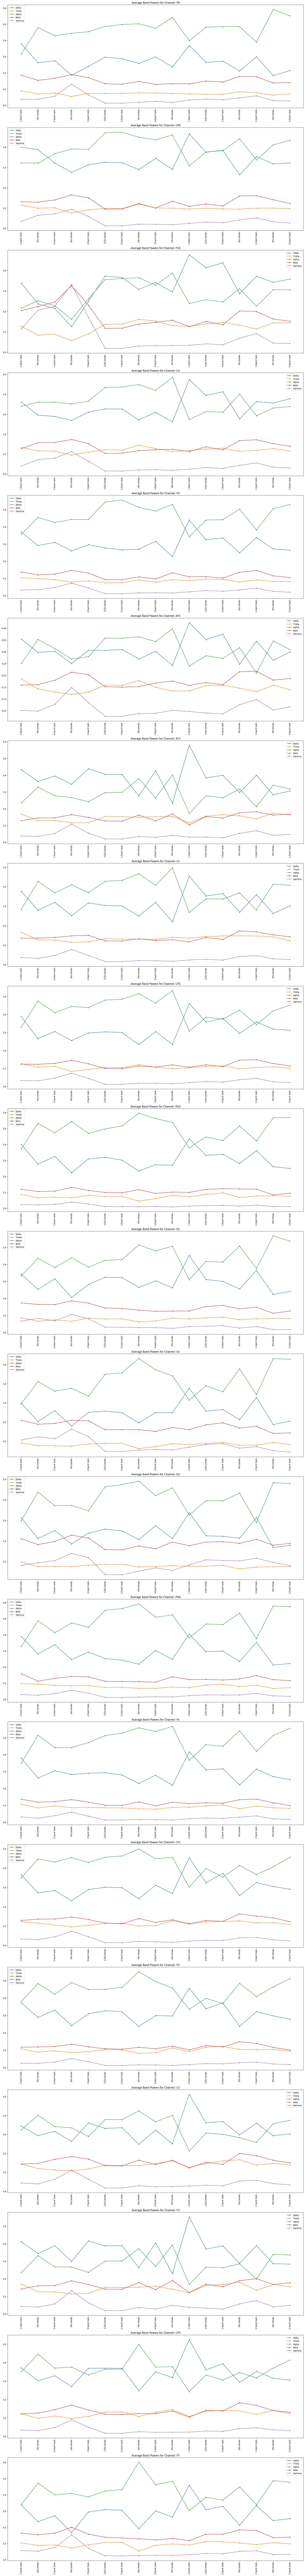

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,168))
for i in range(21):
  ax = fig.add_subplot(21,1,i+1)
  plt.plot(range(len(xLabels)),deltaBP.T[i], marker=".")
  plt.plot(range(len(xLabels)),thetaBP.T[i], marker=".")
  plt.plot(range(len(xLabels)),alphaBP.T[i], marker=".")
  plt.plot(range(len(xLabels)),betaBP.T[i], marker=".")
  plt.plot(range(len(xLabels)),gammaBP.T[i], marker=".")
  ax.set_title(f"Average Band Powers for Channel: {finalChannels[i]}")
  plt.legend(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
  plt.xticks(range(len(xLabels)),xLabels,rotation=90)
plt.tight_layout()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Figure(1000x350)


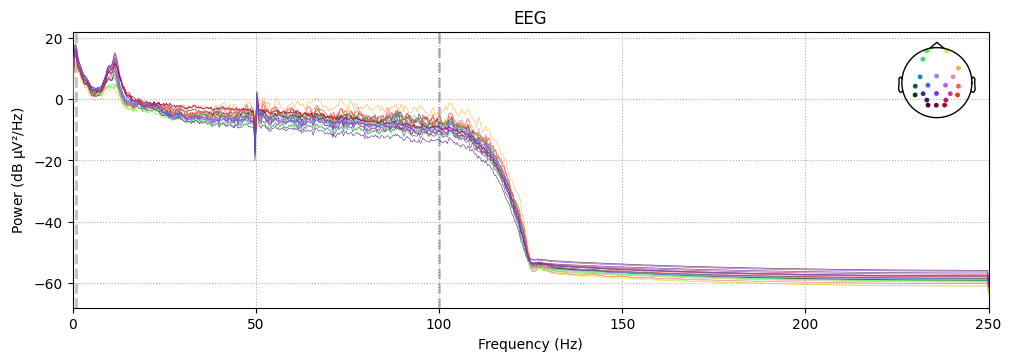

In [ ]:
print(eeg_raw.plot_psd())

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Figure(1000x350)


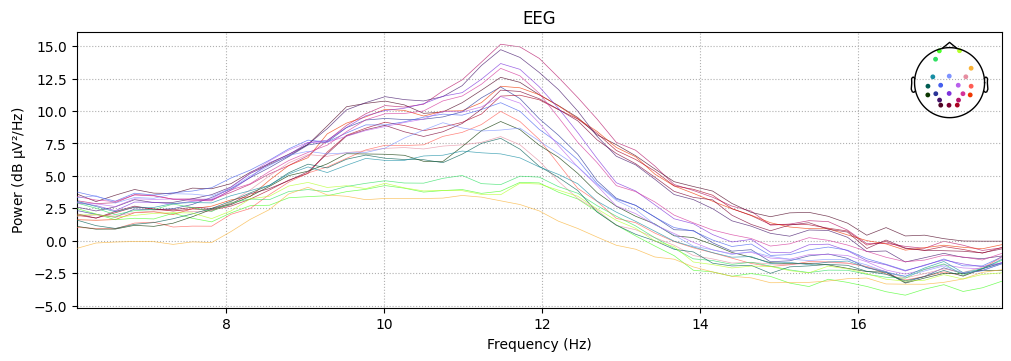

In [ ]:
print(eeg_raw.plot_psd(fmin=6, fmax=18))